In [ ]:
!pip install ultralytics torch torchvision matplotlib opencv-python

In [22]:
from ultralytics import YOLO
import torch
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
from collections import Counter
import shutil
import random
from torchvision import models
import torch.nn as nn

In [25]:
# Caminhos
YOLO_DATASET_PATH = "/Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset-yolo-completo"
CNN_MODEL_PATH = "best_model.pt"  # Caminho do modelo de classificação de logos
YOLO_MODEL_PATH = "runs_yolo/logo_detector/weights/best.pt"  # Modelo YOLO treinado 

# GPU
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
print("🖥️ Dispositivo ativo:", DEVICE)

🖥️ Dispositivo ativo: mps


### 🖼️ Estrutura e Visualização do Dataset YOLOv8 

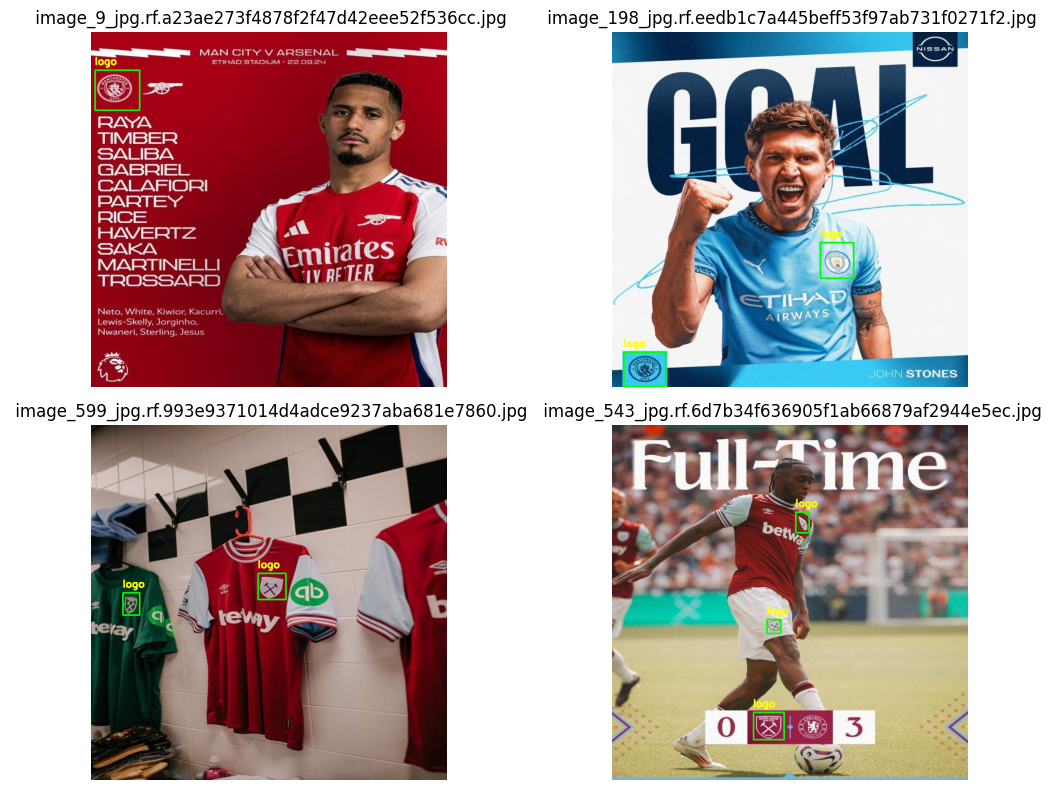

In [18]:
# Caminhos
train_img_dir = os.path.join(YOLO_DATASET_PATH, "train", "images")
train_lbl_dir = os.path.join(YOLO_DATASET_PATH, "train", "labels")

# Função para ler bounding boxes do formato YOLO
def read_yolo_labels(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        cls, x, y, w, h = map(float, line.strip().split())
        boxes.append((cls, x, y, w, h))
    return boxes

# Função para desenhar boxes
def draw_boxes(img_path, label_path):
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    h, w, _ = image.shape
    boxes = read_yolo_labels(label_path)

    for cls, x, y, bw, bh in boxes:
        x1 = int((x - bw / 2) * w)
        y1 = int((y - bh / 2) * h)
        x2 = int((x + bw / 2) * w)
        y2 = int((y + bh / 2) * h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"logo", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    
    return image

# Escolher imagens aleatórias
samples = random.sample(os.listdir(train_img_dir), 4)
plt.figure(figsize=(12, 8))
for idx, sample in enumerate(samples):
    img_path = os.path.join(train_img_dir, sample)
    label_path = os.path.join(train_lbl_dir, sample.replace('.jpg', '.txt').replace('.png', '.txt'))
    annotated_img = draw_boxes(img_path, label_path)
    plt.subplot(2, 2, idx+1)
    plt.imshow(annotated_img)
    plt.title(f" {sample}")
    plt.axis('off')
plt.tight_layout()
plt.show()


### ⚽🎯 Treino do YOLOv8 — Detetor de Emblemas

In [41]:
# Inicializar modelo base YOLOv8
model = YOLO("yolov8n.pt")

# Caminho para o ficheiro data.yaml (já gerado pelo Roboflow)
yaml_path = os.path.join(YOLO_DATASET_PATH, "data.yaml")

# Treinar modelo YOLO
model.train(
    data=yaml_path,
    epochs=50,
    imgsz=640,
    batch=16,
    project="runs_yolo",
    name="logo_detector",
    val=True,
    exist_ok=True  
)

New https://pypi.org/project/ultralytics/8.3.154 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.151 🚀 Python-3.9.6 torch-2.7.0 CPU (Apple M4)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset-yolo-completo/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=

train: Scanning /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset-yolo-completo/train/labels... 213 images, 0 backgrounds, 0 corrupt: 100%|██████████| 213/213 [00:00<00:00, 6094.25it/s]

train: New cache created: /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset-yolo-completo/train/labels.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 226.7±82.7 MB/s, size: 54.2 KB)



val: Scanning /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset-yolo-completo/valid/labels... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<00:00, 5441.92it/s]

val: New cache created: /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset-yolo-completo/valid/labels.cache
Plotting labels to runs_yolo/logo_detector/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs_yolo/logo_detector
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50         0G      1.733       3.86       1.33         16        640: 100%|██████████| 14/14 [00:51<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.80s/it]

                   all         50         69    0.00447      0.971      0.073     0.0373

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       2/50         0G      1.518      2.635      1.151          4        640: 100%|██████████| 14/14 [00:49<00:00,  3.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.80s/it]

                   all         50         69    0.00453      0.986      0.114     0.0724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       3/50         0G      1.526      2.261      1.147         11        640: 100%|██████████| 14/14 [00:49<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.78s/it]

                   all         50         69    0.00393      0.855    0.00664    0.00384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       4/50         0G       1.51      2.175      1.164          8        640: 100%|██████████| 14/14 [00:49<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]

                   all         50         69      0.643      0.029     0.0309     0.0181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       5/50         0G      1.514       1.92      1.175         12        640: 100%|██████████| 14/14 [00:49<00:00,  3.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]

                   all         50         69          1     0.0286     0.0406     0.0224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       6/50         0G      1.467       1.86      1.177          8        640: 100%|██████████| 14/14 [00:49<00:00,  3.57s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.85s/it]

                   all         50         69          1      0.151      0.462      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       7/50         0G      1.394      1.644      1.148         17        640: 100%|██████████| 14/14 [00:49<00:00,  3.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]

                   all         50         69      0.659      0.406      0.469      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       8/50         0G      1.451      1.655      1.197          8        640: 100%|██████████| 14/14 [00:49<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]

                   all         50         69      0.628      0.464      0.431      0.206

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



       9/50         0G      1.453      1.505      1.172         14        640: 100%|██████████| 14/14 [00:50<00:00,  3.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  3.00s/it]

                   all         50         69      0.677      0.464      0.549      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      10/50         0G      1.497       1.53      1.194         10        640: 100%|██████████| 14/14 [00:51<00:00,  3.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.99s/it]

                   all         50         69      0.586      0.536      0.583      0.315

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      11/50         0G      1.502       1.44      1.162          7        640: 100%|██████████| 14/14 [00:52<00:00,  3.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.98s/it]

                   all         50         69      0.683      0.594      0.672      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      12/50         0G      1.421      1.346      1.152         20        640: 100%|██████████| 14/14 [11:15<00:00, 48.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         50         69      0.784      0.681      0.729      0.285

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      13/50         0G      1.388      1.458      1.147          5        640: 100%|██████████| 14/14 [00:50<00:00,  3.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]

                   all         50         69      0.879      0.736      0.838      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      14/50         0G      1.416       1.22      1.171          5        640: 100%|██████████| 14/14 [00:52<00:00,  3.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.83s/it]

                   all         50         69      0.769      0.725      0.782      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      15/50         0G      1.485      1.298      1.197          7        640: 100%|██████████| 14/14 [00:49<00:00,  3.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.77s/it]

                   all         50         69      0.791      0.739      0.817      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      16/50         0G      1.378      1.208      1.139          9        640: 100%|██████████| 14/14 [00:50<00:00,  3.62s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.78s/it]

                   all         50         69      0.783      0.652      0.729      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         0G       1.36      1.144        1.1         15        640: 100%|██████████| 14/14 [00:49<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.78s/it]

                   all         50         69       0.78       0.71       0.77      0.404

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      18/50         0G      1.366      1.094      1.116          8        640: 100%|██████████| 14/14 [00:49<00:00,  3.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.80s/it]

                   all         50         69      0.774      0.797      0.816      0.465

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      19/50         0G      1.311      1.101      1.111          8        640: 100%|██████████| 14/14 [00:51<00:00,  3.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  3.00s/it]

                   all         50         69      0.836      0.739      0.841      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      20/50         0G      1.364       1.04      1.105          8        640: 100%|██████████| 14/14 [00:52<00:00,  3.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         50         69      0.857      0.696      0.807      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      21/50         0G      1.329      1.039      1.122          7        640: 100%|██████████| 14/14 [00:53<00:00,  3.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]

                   all         50         69      0.889      0.725      0.833      0.439

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      22/50         0G      1.316      1.022      1.116         11        640: 100%|██████████| 14/14 [00:53<00:00,  3.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         50         69      0.869      0.768      0.848      0.428

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      23/50         0G      1.287     0.9691      1.092         13        640: 100%|██████████| 14/14 [00:53<00:00,  3.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]

                   all         50         69      0.774      0.783      0.847      0.462

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      24/50         0G      1.278     0.8912      1.089          7        640: 100%|██████████| 14/14 [00:53<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         50         69      0.809      0.826      0.857      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      25/50         0G      1.215     0.8616      1.058         12        640: 100%|██████████| 14/14 [00:53<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.12s/it]

                   all         50         69      0.742      0.768      0.816      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      26/50         0G      1.306     0.8861      1.096         20        640: 100%|██████████| 14/14 [00:54<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.14s/it]

                   all         50         69      0.835       0.71      0.814      0.438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      27/50         0G      1.284     0.8286       1.05         13        640: 100%|██████████| 14/14 [00:56<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.18s/it]

                   all         50         69      0.893      0.723      0.865      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      28/50         0G      1.286     0.8756      1.093         11        640: 100%|██████████| 14/14 [01:00<00:00,  4.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.27s/it]

                   all         50         69      0.825      0.797      0.883      0.498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      29/50         0G      1.224     0.8471      1.058         14        640: 100%|██████████| 14/14 [00:59<00:00,  4.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.39s/it]

                   all         50         69       0.85      0.826      0.876      0.504

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      30/50         0G      1.255     0.8679      1.059          9        640: 100%|██████████| 14/14 [01:00<00:00,  4.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.89s/it]

                   all         50         69      0.789       0.76      0.814      0.418

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      31/50         0G       1.19     0.8133      1.049         18        640: 100%|██████████| 14/14 [01:00<00:00,  4.32s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]

                   all         50         69      0.841      0.846      0.886       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      32/50         0G      1.174     0.7635      1.047          9        640: 100%|██████████| 14/14 [00:56<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         50         69      0.839      0.841       0.87      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      33/50         0G      1.234     0.8271      1.054          9        640: 100%|██████████| 14/14 [00:53<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         50         69      0.876      0.819      0.885      0.501

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      34/50         0G      1.135     0.7147      1.036          9        640: 100%|██████████| 14/14 [00:53<00:00,  3.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         50         69       0.84      0.836      0.895      0.539

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      35/50         0G      1.163     0.7247      1.042          3        640: 100%|██████████| 14/14 [00:53<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.05s/it]

                   all         50         69      0.837      0.841      0.892      0.525

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      36/50         0G      1.147     0.7264      1.012         11        640: 100%|██████████| 14/14 [00:53<00:00,  3.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.04s/it]

                   all         50         69      0.865      0.839      0.899       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      37/50         0G      1.175     0.7323      1.043         12        640: 100%|██████████| 14/14 [00:53<00:00,  3.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]

                   all         50         69      0.815       0.87      0.898        0.5

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      38/50         0G      1.153     0.7231      1.043         12        640: 100%|██████████| 14/14 [00:56<00:00,  4.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.17s/it]

                   all         50         69      0.782       0.87      0.894      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      39/50         0G      1.169     0.7411     0.9962         18        640: 100%|██████████| 14/14 [00:54<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.17s/it]

                   all         50         69      0.805      0.898       0.91      0.478

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      40/50         0G      1.165     0.7071      1.023         14        640: 100%|██████████| 14/14 [00:55<00:00,  3.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.19s/it]

                   all         50         69       0.87       0.87      0.936      0.542
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      41/50         0G      1.134     0.6992      1.046          7        640: 100%|██████████| 14/14 [00:55<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.18s/it]

                   all         50         69      0.824      0.885      0.927      0.558

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      42/50         0G      1.095     0.6578       1.04          5        640: 100%|██████████| 14/14 [00:54<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         50         69      0.924      0.812      0.922      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      43/50         0G      1.067     0.6648      1.038         10        640: 100%|██████████| 14/14 [00:54<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         50         69      0.902      0.797       0.91       0.53

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      44/50         0G      1.099     0.6759      1.034          7        640: 100%|██████████| 14/14 [00:54<00:00,  3.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]

                   all         50         69      0.916      0.787       0.92      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50         0G      1.062     0.6242      0.998          9        640: 100%|██████████| 14/14 [00:54<00:00,  3.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         50         69      0.904      0.797      0.928      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      46/50         0G      1.054     0.6071      1.014          8        640: 100%|██████████| 14/14 [00:54<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.10s/it]

                   all         50         69      0.893      0.844      0.917      0.534

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      47/50         0G      1.005     0.6103     0.9808         12        640: 100%|██████████| 14/14 [00:54<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         50         69      0.875      0.841      0.916      0.543

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      48/50         0G     0.9772     0.5676     0.9797          6        640: 100%|██████████| 14/14 [00:54<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         50         69       0.89      0.817      0.912      0.528

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      49/50         0G      1.013     0.5811     0.9802          9        640: 100%|██████████| 14/14 [00:54<00:00,  3.86s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         50         69      0.902      0.826      0.912      0.527

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      50/50         0G      1.006     0.5799     0.9755          8        640: 100%|██████████| 14/14 [00:54<00:00,  3.87s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.11s/it]

                   all         50         69      0.895      0.826      0.913      0.535

50 epochs completed in 0.999 hours.
Optimizer stripped from runs_yolo/logo_detector/weights/last.pt, 6.3MB
Optimizer stripped from runs_yolo/logo_detector/weights/best.pt, 6.3MB

Validating runs_yolo/logo_detector/weights/best.pt...
Ultralytics 8.3.151 🚀 Python-3.9.6 torch-2.7.0 CPU (Apple M4)


Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.06s/it]


                   all         50         69      0.824      0.884      0.927      0.558
Speed: 0.8ms preprocess, 116.8ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs_yolo/logo_detector


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x15ecc75e0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048,    

In [42]:
model = YOLO("runs_yolo/logo_detector/weights/best.pt")
print(model.names)

{0: 'logo'}


### 🧠📸 Inferência com o YOLOv8 — Deteção de Emblemas em Imagens 



image 1/1 /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset-yolo-completo/test/images/5.jpg: 384x640 3 logos, 21.7ms
Speed: 1.0ms preprocess, 21.7ms inference, 0.3ms postprocess per image at shape (1, 3, 384, 640)
3 emblemas detetados.


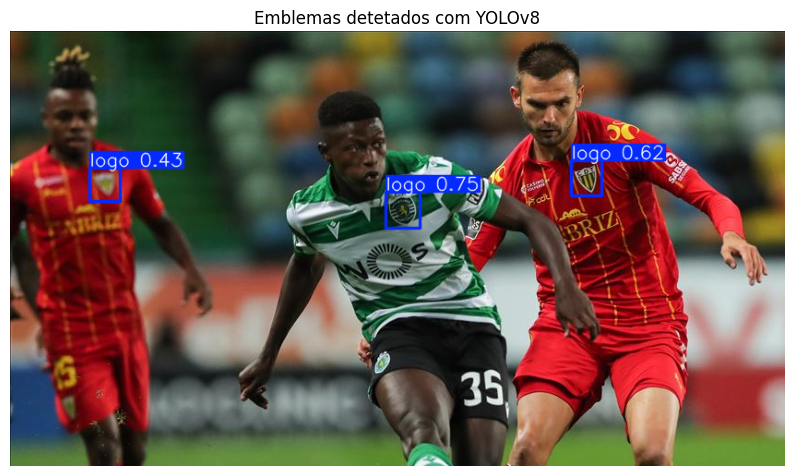

In [45]:
# Carregar o modelo YOLO treinado
detector = YOLO(YOLO_MODEL_PATH)

# Caminho para uma imagem de teste (jogo real)
test_image_path = "/Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset-yolo-completo/test/images/5.jpg"  # substituir nome da imagem

# Inferência com YOLO
results = detector(test_image_path, conf=0.3)

# Verificar se houve alguma deteção
if results[0].boxes is not None and len(results[0].boxes) > 0:
    print(f"{len(results[0].boxes)} emblemas detetados.")
    output_image = results[0].plot()
    output_image = cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB)  # corrigir azul
    plt.figure(figsize=(10, 6))
    plt.imshow(output_image)
    plt.axis('off')
    plt.title("Emblemas detetados com YOLOv8")
    plt.show()
else:
    print("Nenhuma deteção encontrada — verificar confiança, qualidade ou treino.")


### 🔍➡️🧠 Recorte da Zona Detetada + Classificação com CNN

In [ ]:
# Transformações (iguais às usadas no treino da CNN)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# Mapeamento das classes
class_names = sorted(os.listdir("/Users/pedrofs/.../augmented-flat"))  # atualiza caminho correto

# Carregar modelo CNN treinado
cnn = models.resnet18(pretrained=False)
cnn.fc = nn.Linear(cnn.fc.in_features, len(class_names))
cnn.load_state_dict(torch.load(CNN_MODEL_PATH, map_location=DEVICE))
cnn = cnn.to(DEVICE)
cnn.eval()

# Abrir imagem original com PIL
image = Image.open(test_image_path).convert("RGB")
image_w, image_h = image.size

# Classificar cada bounding box detetada pelo YOLO
results = detector(test_image_path, conf=0.4)
preds = []

for box in results[0].boxes.xywh:  # xywh = center_x, center_y, width, height
    cx, cy, bw, bh = box
    x1 = int((cx - bw / 2).item())
    y1 = int((cy - bh / 2).item())
    x2 = int((cx + bw / 2).item())
    y2 = int((cy + bh / 2).item())

    # Recorte e transformação
    cropped = image.crop((x1, y1, x2, y2))
    input_tensor = transform(cropped).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = cnn(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        pred_clube = class_names[pred_idx]
        preds.append(pred_clube)

# Mostrar resultados
print(" Clubes detetados na imagem:")
for i, p in enumerate(preds, 1):
    print(f"{i}. {p}")
